In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#display data frame nicely
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

In [2]:
#read the parquet file and sort dates
data = pd.read_parquet(r"Data\DATA10.parquet")
data = data.sort_index()

Calculating essential figures which will be useful in our analysis e.g net posions, weekly,bi-weekly returns

In [3]:
data['noncomm_netpos_oil'] = data['noncomm_long_oil'] - data['noncomm_short_oil']
data['comm_netpos_oil'] = data['comm_long_oil'] - data['comm_short_oil']
data['noncomm_netpos_euro'] = data['noncomm_long_euro'] - data['noncomm_short_euro']
data['comm_netpos_euro'] = data['comm_long_euro'] - data['comm_short_euro']
data['noncomm_netpos_es'] = data['noncomm_long_es'] - data['noncomm_short_es']
data['comm_netpos_es'] = data['comm_long_es'] - data['comm_short_es']

In [4]:
data['returns1w_oil'] = data['oil_price'].pct_change()
data['returns1w_euro'] = data['euro_price'].pct_change()
data['returns1w_es'] = data['es_price'].pct_change()



In [5]:
data['fut_returns1w_oil'] = data['returns1w_oil'].shift(-1)
data['fut_returns1w_euro'] = data['returns1w_euro'].shift(-1)
data['fut_returns1w_es'] = data['returns1w_es'].shift(-1)

data['fut_returns2w_oil'] = data['returns1w_oil'].shift(-2)
data['fut_returns2w_euro'] = data['returns1w_euro'].shift(-2)
data['fut_returns2w_es'] = data['returns1w_es'].shift(-2)

data['fut_returns4w_oil'] = data['returns1w_oil'].shift(-4)
data['fut_returns4w_euro'] = data['returns1w_euro'].shift(-4)
data['fut_returns4w_es'] = data['returns1w_es'].shift(-4)


Zscores on Net positions are important in this analysis because using raw netpostions doesn't show any statistical importance

In [6]:
def zscore(series, window=52):
    return( series -
 series.rolling(window).mean()) /series.rolling(window).std()

data['noncomm_z_oil'] = zscore(data['noncomm_netpos_oil'])
data['comm_z_oil'] = zscore(data['comm_netpos_oil'])
data['noncomm_z_euro'] = zscore(data['noncomm_netpos_euro'])
data['comm_z_euro'] = zscore(data['comm_netpos_euro'])
data['noncomm_z_es'] = zscore(data['noncomm_netpos_es'])
data['comm_z_es'] = zscore(data['comm_netpos_es'])


Function To Calculate Correlations In Zscoores and Returns

In [7]:
asset_cols = {
    "oil":{
        "cot":["comm_z_oil","noncomm_z_oil"],
        "returns": ["fut_returns1w_oil","fut_returns2w_oil","fut_returns4w_oil"]
    },
    "euro": {
        "cot":["comm_z_euro","noncomm_z_euro"],
        "returns": ["fut_returns1w_euro","fut_returns2w_euro","fut_returns4w_euro"]
    },
    "es": {
        "cot":["comm_z_es","noncomm_z_es"],
        "returns": ["fut_returns1w_es","fut_returns2w_es","fut_returns4w_es"]
    }
}

def cot_corr(data, cot_cols, future_cols):
    clean_data = data[cot_cols + future_cols].dropna()
    corr_matrix = clean_data.corr()
    return corr_matrix.loc[cot_cols, future_cols].round(4)



In [8]:
oil_corr = cot_corr(data,
                    asset_cols["oil"]["cot"],
                    asset_cols["oil"]["returns"])
euro_corr = cot_corr(data,                               #
                    asset_cols["euro"]["cot"],
                    asset_cols["euro"]["returns"])
es_corr = cot_corr(data,
                    asset_cols["es"]["cot"],
                    asset_cols["es"]["returns"])


In [9]:
euro_corr

,fut_returns1w_euro,fut_returns2w_euro,fut_returns4w_euro
comm_z_euro,-0.0682,-0.0822,-0.0972
noncomm_z_euro,0.0654,0.0831,0.0966


In [10]:
es_corr

,fut_returns1w_es,fut_returns2w_es,fut_returns4w_es
comm_z_es,0.0104,0.0188,0.0062
noncomm_z_es,-0.0204,-0.0158,-0.0271


In [11]:
oil_corr

,fut_returns1w_oil,fut_returns2w_oil,fut_returns4w_oil
comm_z_oil,-0.0206,-0.0200,-0.0116
noncomm_z_oil,0.0301,0.0256,0.0082


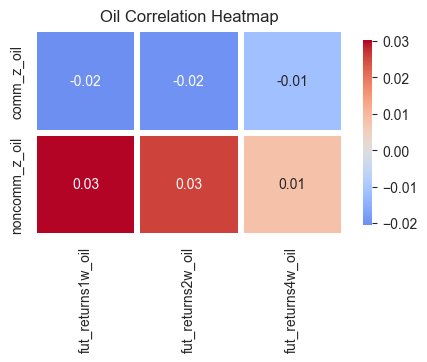

In [12]:
plt.figure(figsize=(5, 3))
# Heatmap
sns.heatmap(
    oil_corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=3,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
#  title
plt.title('Oil Correlation Heatmap', fontsize=12)

# SAVE
plt.savefig('oil_correlation_heatmap.png', dpi=300 , bbox_inches='tight',  facecolor='white')
plt.show()

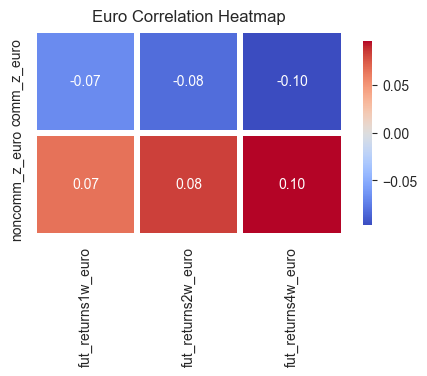

In [13]:
plt.figure(figsize=(5, 3))
# Heatmap
sns.heatmap(
    euro_corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=3,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
#  title
plt.title('Euro Correlation Heatmap', fontsize=12)

# SAVE
plt.savefig('euro_correlation_heatmap.png', dpi=300 , bbox_inches='tight',  facecolor='white')
plt.show()

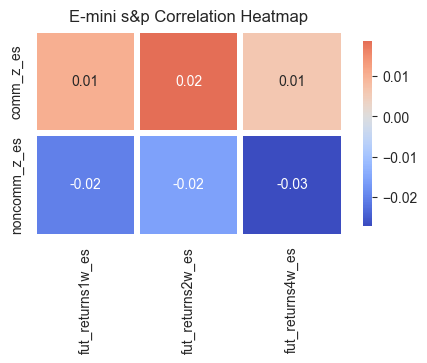

In [14]:
plt.figure(figsize=(5, 3))
# Heatmap
sns.heatmap(
    es_corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=3,
    square=True,
    fmt=".2f",
    cbar_kws={"shrink": 0.8}
)
#  title
plt.title('E-mini s&p Correlation Heatmap', fontsize=12)

# SAVE
plt.savefig('es_correlation_heatmap.png', dpi=300 , bbox_inches='tight',  facecolor='white')
plt.show()

In [15]:

THRESHOLD = 2.0
# A dictionary to store columns needed
assets_to_analyze = {
    'Euro': {
        'zscore_col': 'noncomm_z_euro',
        'ret_1w': 'fut_returns1w_euro',
        'ret_2w': 'fut_returns2w_euro'
    },
    'Oil': {
        'zscore_col': 'noncomm_z_oil',
        'ret_1w': 'fut_returns1w_oil',
        'ret_2w': 'fut_returns2w_oil'
    },
    'ES': {
        'zscore_col': 'noncomm_z_es',
        'ret_1w': 'fut_returns1w_es',
        'ret_2w': 'fut_returns2w_es'
    }
}

print(f"--- Extreme Non-Commercial Positioning Analysis (+/- {THRESHOLD} SD) ---")
print("Forward horizons: 1 week vs 2 weeks\n")

results = []

for asset_name, cols in assets_to_analyze.items():
    z_col = cols['zscore_col']
    ret_1w = cols['ret_1w']
    ret_2w = cols['ret_2w']

    # Safety check for columns
    missing = [c for c in [z_col, ret_1w, ret_2w] if c not in data.columns]
    if missing:
        print(f"Warning: Missing columns {missing} for {asset_name}, skipping.\n")
        continue

    # Overbought: extreme speculative long
    overbought = data[data[z_col] > THRESHOLD]
    count_ob = len(overbought)
    avg_1w_ob = overbought[ret_1w].mean() * 100 if count_ob > 0 else float('nan')
    avg_2w_ob = overbought[ret_2w].mean() * 100 if count_ob > 0 else float('nan')

    # Oversold: extreme speculative short
    oversold = data[data[z_col] < -THRESHOLD]
    count_os = len(oversold)
    avg_1w_os = oversold[ret_1w].mean() * 100 if count_os > 0 else float('nan')
    avg_2w_os = oversold[ret_2w].mean() * 100 if count_os > 0 else float('nan')

    print(f"[{asset_name}]")
    print(f"  Overbought (> +{THRESHOLD}): {count_ob} signals")
    print(f"    → 1W return: {avg_1w_ob:+.4f}%  |  2W return: {avg_2w_ob:+.4f}%")
    print(f"  Oversold   (< -{THRESHOLD}): {count_os} signals")
    print(f"    → 1W return: {avg_1w_os:+.4f}%  |  2W return: {avg_2w_os:+.4f}%\n")

    # Collect results for summary table
    results.append({
        'Asset': asset_name,
        'Signal': 'Overbought',
        'Count': count_ob,
        '1W Avg Return (%)': round(avg_1w_ob, 4) if not pd.isna(avg_1w_ob) else None,
        '2W Avg Return (%)': round(avg_2w_ob, 4) if not pd.isna(avg_2w_ob) else None,
    })
    results.append({
        'Asset': asset_name,
        'Signal': 'Oversold',
        'Count': count_os,
        '1W Avg Return (%)': round(avg_1w_os, 4) if not pd.isna(avg_1w_os) else None,
        '2W Avg Return (%)': round(avg_2w_os, 4) if not pd.isna(avg_2w_os) else None,
    })

# Final summary table
if results:
    summary_df_noncomm = pd.DataFrame(results)
    print("=== Summary Table for Non-Commercials (1W vs 2W Returns) ===")
    print(summary_df_noncomm.to_string(index=False))

--- Extreme Non-Commercial Positioning Analysis (+/- 2.0 SD) ---
Forward horizons: 1 week vs 2 weeks

[Euro]
  Overbought (> +2.0): 48 signals
    → 1W return: +0.2145%  |  2W return: +0.2264%
  Oversold   (< -2.0): 61 signals
    → 1W return: +0.0636%  |  2W return: -0.1253%

[Oil]
  Overbought (> +2.0): 50 signals
    → 1W return: +2.3363%  |  2W return: +1.8669%
  Oversold   (< -2.0): 37 signals
    → 1W return: +0.5152%  |  2W return: +0.6235%

[ES]
  Overbought (> +2.0): 41 signals
    → 1W return: +0.3379%  |  2W return: +0.2541%
  Oversold   (< -2.0): 46 signals
    → 1W return: +0.8392%  |  2W return: +0.6557%

=== Summary Table for Non-Commercials (1W vs 2W Returns) ===
Asset     Signal  Count  1W Avg Return (%)  2W Avg Return (%)
 Euro Overbought     48             0.2145             0.2264
 Euro   Oversold     61             0.0636            -0.1253
  Oil Overbought     50             2.3363             1.8669
  Oil   Oversold     37             0.5152             0.6235
  

In [16]:

THRESHOLD = 2.0
# dictionary to store the columns needed
assets_to_analyze = {
    'Euro': {
        'zscore_col': 'comm_z_euro',
        'ret_1w': 'fut_returns1w_euro',
        'ret_2w': 'fut_returns2w_euro'
    },
    'Oil': {
        'zscore_col': 'comm_z_oil',
        'ret_1w': 'fut_returns1w_oil',
        'ret_2w': 'fut_returns2w_oil'
    },
    'ES': {
        'zscore_col': 'comm_z_es',
        'ret_1w': 'fut_returns1w_es',
        'ret_2w': 'fut_returns2w_es'
    }
}

print(f"--- Extreme Commercial Positioning Analysis (+/- {THRESHOLD} SD) ---")
print("Forward horizons: 1 week vs 2 weeks\n")

results = []

for asset_name, cols in assets_to_analyze.items():
    z_col = cols['zscore_col']
    ret_1w = cols['ret_1w']
    ret_2w = cols['ret_2w']

    # Safety check for columns
    missing = [c for c in [z_col, ret_1w, ret_2w] if c not in data.columns]
    if missing:
        print(f"Warning: Missing columns {missing} for {asset_name}, skipping.\n")
        continue

    # Overbought: extreme commercial long
    overbought = data[data[z_col] > THRESHOLD]
    count_ob = len(overbought)
    avg_1w_ob = overbought[ret_1w].mean() * 100 if count_ob > 0 else float('nan')
    avg_2w_ob = overbought[ret_2w].mean() * 100 if count_ob > 0 else float('nan')

    # Oversold: extreme commercial short
    oversold = data[data[z_col] < -THRESHOLD]
    count_os = len(oversold)
    avg_1w_os = oversold[ret_1w].mean() * 100 if count_os > 0 else float('nan')
    avg_2w_os = oversold[ret_2w].mean() * 100 if count_os > 0 else float('nan')

    print(f"[{asset_name}]")
    print(f"  Overbought (> +{THRESHOLD}): {count_ob} signals")
    print(f"    → 1W return: {avg_1w_ob:+.4f}%  |  2W return: {avg_2w_ob:+.4f}%")
    print(f"  Oversold   (< -{THRESHOLD}): {count_os} signals")
    print(f"    → 1W return: {avg_1w_os:+.4f}%  |  2W return: {avg_2w_os:+.4f}%\n")

    # Collect results for summary table
    results.append({
        'Asset': asset_name,
        'Signal': 'Overbought',
        'Count': count_ob,
        '1W Avg Return (%)': round(avg_1w_ob, 4) if not pd.isna(avg_1w_ob) else None,
        '2W Avg Return (%)': round(avg_2w_ob, 4) if not pd.isna(avg_2w_ob) else None,
    })
    results.append({
        'Asset': asset_name,
        'Signal': 'Oversold',
        'Count': count_os,
        '1W Avg Return (%)': round(avg_1w_os, 4) if not pd.isna(avg_1w_os) else None,
        '2W Avg Return (%)': round(avg_2w_os, 4) if not pd.isna(avg_2w_os) else None,
    })

# Final summary table
if results:
    summary_df_comm = pd.DataFrame(results)
    print("=== Summary Table for Commercials (1W vs 2W Returns) ===")
    print(summary_df_comm.to_string(index=False))

--- Extreme Commercial Positioning Analysis (+/- 2.0 SD) ---
Forward horizons: 1 week vs 2 weeks

[Euro]
  Overbought (> +2.0): 58 signals
    → 1W return: -0.0187%  |  2W return: -0.0655%
  Oversold   (< -2.0): 53 signals
    → 1W return: +0.2606%  |  2W return: +0.2379%

[Oil]
  Overbought (> +2.0): 33 signals
    → 1W return: +0.2719%  |  2W return: +0.6593%
  Oversold   (< -2.0): 54 signals
    → 1W return: +2.2110%  |  2W return: +1.6280%

[ES]
  Overbought (> +2.0): 38 signals
    → 1W return: +0.2965%  |  2W return: +0.4775%
  Oversold   (< -2.0): 41 signals
    → 1W return: -0.1020%  |  2W return: +0.0252%

=== Summary Table for Commercials (1W vs 2W Returns) ===
Asset     Signal  Count  1W Avg Return (%)  2W Avg Return (%)
 Euro Overbought     58            -0.0187            -0.0655
 Euro   Oversold     53             0.2606             0.2379
  Oil Overbought     33             0.2719             0.6593
  Oil   Oversold     54             2.2110             1.6280
   ES Over

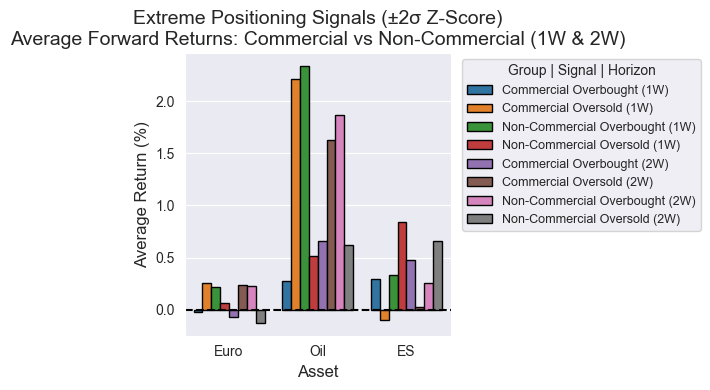

In [17]:
summary_df_comm['Group'] = 'Commercial'          #  commercial df
summary_df_noncomm['Group'] = 'Non-Commercial'   #  non-commercial df


combined_df = pd.concat([summary_df_comm, summary_df_noncomm], ignore_index=True)

#  Melt to long format for plotting
df_long = combined_df.melt(
    id_vars=['Asset', 'Group', 'Signal'],
    value_vars=['1W Avg Return (%)', '2W Avg Return (%)'],
    var_name='Horizon',
    value_name='Avg Return (%)'
)

# Creating a clean label for the legend
df_long['Label'] = df_long['Group'] + ' ' + df_long['Signal'] + ' (' + df_long['Horizon'].str[:2] + ')'

plt.figure(figsize=(6, 4))

# Using a palette that separates groups
sns.barplot(
    data=df_long,
    x='Asset',
    y='Avg Return (%)',
    hue='Label',
    palette='tab10',
    edgecolor='black',
    linewidth=1
)

plt.title('Extreme Positioning Signals (±2σ Z-Score)\nAverage Forward Returns: Commercial vs Non-Commercial (1W & 2W)', fontsize=14)
plt.axhline(0, color='black', linewidth=1.5, linestyle='--')
plt.ylabel('Average Return (%)', fontsize=12)
plt.xlabel('Asset', fontsize=12)
plt.legend(title='Group | Signal | Horizon', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
plt.tight_layout()

# Step 6: Save the chart
plt.savefig('cot_positioning_extremes_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

Rolling correlations to show strenght of relationship between assets overtime


In [18]:
print("Window: 52 weeks | Value shown: Average correlation over full period\n")

assets = ['euro', 'oil', 'es']
window = 52

for asset in assets:
    comm_col = f'comm_z_{asset}'
    noncomm_col = f'noncomm_z_{asset}'

    # Calculate rolling correlation
    rolling_corr = data[comm_col].rolling(window=window).corr(data[noncomm_col])

    # Drop NaN due to first 51 weeks not having full window
    avg_corr = rolling_corr.dropna().mean()

    print(f"{asset:4} | Average rolling correlation: {avg_corr:.3f}")

print("\nInterpretation:")
print("   Closer to -1.0 : Commercials and Non-Commercials strongly mirror each other")
print("   Closer to  0.0 : Their positioning relationship is weak or changes a lot")

Window: 52 weeks | Value shown: Average correlation over full period

euro | Average rolling correlation: -0.991
oil  | Average rolling correlation: -0.984
es   | Average rolling correlation: -0.593

Interpretation:
   Closer to -1.0 : Commercials and Non-Commercials strongly mirror each other
   Closer to  0.0 : Their positioning relationship is weak or changes a lot


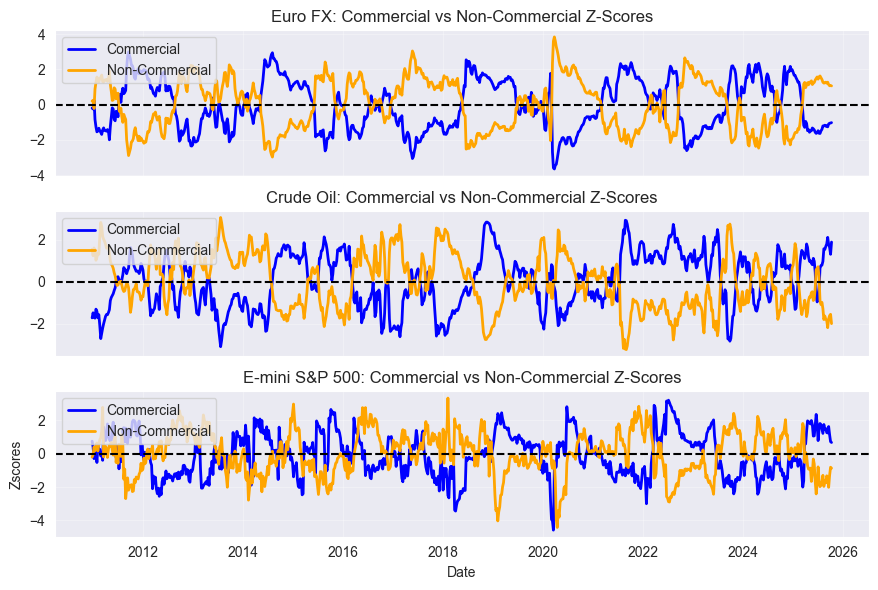

In [23]:
import matplotlib.pyplot as plt

# Create 3 subplots stacked vertically
fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)

# 1. Euro FX
axs[0].plot(data.index, data['comm_z_euro'],
            label='Commercial', color='blue', linewidth=2)
axs[0].plot(data.index, data['noncomm_z_euro'],
            label='Non-Commercial', color='orange', linewidth=2)
axs[0].set_title('Euro FX: Commercial vs Non-Commercial Z-Scores')
axs[0].axhline(0, color='black', linestyle='--')
axs[0].legend(loc='upper left')
axs[0].grid(alpha=0.3)

# 2. Crude Oil
axs[1].plot(data.index, data['comm_z_oil'],
            label='Commercial', color='blue', linewidth=2)
axs[1].plot(data.index, data['noncomm_z_oil'],
            label='Non-Commercial', color='orange', linewidth=2)
axs[1].set_title('Crude Oil: Commercial vs Non-Commercial Z-Scores')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].legend(loc='upper left')
axs[1].grid(alpha=0.3)

# 3. E-mini S&P 500
axs[2].plot(data.index, data['comm_z_es'],
            label='Commercial', color='blue', linewidth=2)
axs[2].plot(data.index, data['noncomm_z_es'],
            label='Non-Commercial', color='orange', linewidth=2)
axs[2].set_title('E-mini S&P 500: Commercial vs Non-Commercial Z-Scores')
axs[2].axhline(0, color='black', linestyle='--')
axs[2].legend(loc='upper left')
axs[2].grid(alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Zscores')
# Save
plt.tight_layout()
plt.savefig('zscore_chart.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()